$\LaTeX$ macros:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import daft
import pystan
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Here we are trying to model a flux-limited survey.  We suppose that there is a population of objects whose true fluxes, $x$, are log-normally distributed with parameters $\mu$, $\sigma$.  We observe a flux that is log-normally distributed about the true flux with some uncertainty, $\sigma_\mathrm{obs}$: 
$$
\log x_\mathrm{obs} \sim N\left( \log(x), \sigma_\mathrm{obs} \right).
$$

If $x_\mathrm{obs} > x_\mathrm{th}$ for some threshold flux, $x_\mathrm{th}$, then we record $x_\mathrm{obs}$ and the object is "observed."  

We wish to infer the fluxes, population parameters, and actual number of sources in the population.

Here is a random draw from such a survey with reasonable parameters:

In [4]:
mu = 0.0
sigma = 1.0
xth = exp(-0.5)
sigma_obs = 0.5

N = random.poisson(100)
xs_all = exp(mu + sigma*randn(N))
xs_obs_all = exp(log(xs_all) + sigma_obs*randn(N))
obs_sel = xs_obs_all > xth
xs_obs = xs_obs_all[obs_sel]

And a comparison between the distribution of true $x$s (green) and the observed $x$s (blue).

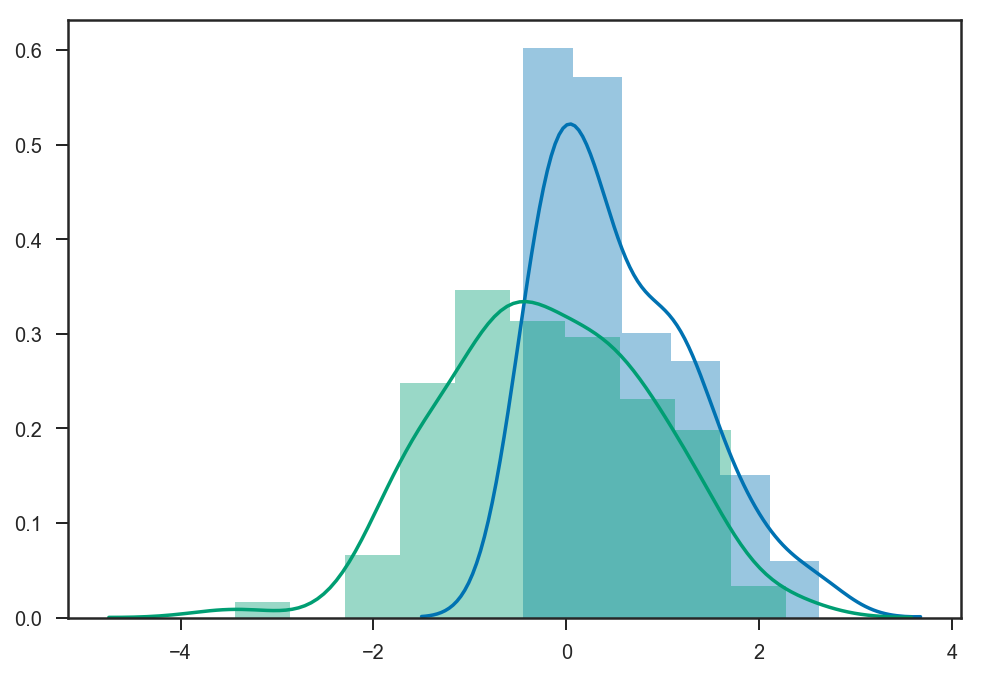

In [5]:
sns.distplot(log(xs_obs))
sns.distplot(log(xs_all))

There are three separate Stan programs in this directory that all sample from this model.  

* `gaussian_analytic.stan` uses the fact that we can analytically compute the fraction of the population that is observable:
$$
\left\langle P_\mathrm{det} \right\rangle \equiv \int \dd x_\mathrm{obs} \, \dd x \, p\left( x_\mathrm{obs} \mid x \right) p\left( x \mid \mu, \sigma \right) P_\mathrm{det}\left( x_\mathrm{obs} \right).
$$
This is because both $p\left( x_\mathrm{obs} \mid x \right)$ and $p\left( x \mid \mu, \sigma \right)$ are log-normal, so marginalising out $x$ leaves 
$$
x_\mathrm{obs} \sim \mathrm{LN} \left( \mu, \sqrt{\sigma^2 + \sigma_\mathrm{obs}^2} \right),
$$
so is given by the complementary CDF of a Gaussian distribution evaluated at the observational threshold:
$$
\left\langle P_\mathrm{det} \right\rangle = 1 - \Phi\left( x_\mathrm{th} \mid \mu, \sqrt{\sigma^2 + \sigma_\mathrm{obs}^2} \right).
$$
The point of this notebook, and project, is that in most instances it is not possible to analytically compute the fraction of systems that are not detected, and so we need a way to estimate these sorts of integrals numerically to fit the population.  The Poisson likelihood for the $N_\mathrm{obs}$ observations is then 
$$
\mathcal{L} = \left[\prod_{i=1}^{N_\mathrm{obs}} P_\mathrm{det}\left( x^i_\mathrm{obs} \right) \Lambda p\left( x^i_\mathrm{obs} \mid x^i \right) p\left( x^i \mid \mu, \sigma \right)\right] \exp\left[ - \Lambda \left\langle P_\mathrm{det} \right \rangle \right]
$$

* `gaussian.stan` uses the MCMC sampler to compute the integrals that calculate $\left\langle P_\mathrm{det} \right\rangle$ by introducing an unknown number of non-detected systems and associated $x$ and $x_\mathrm{obs}$ parameters into the system; the likelihood after marginalising over the number of non-detected systems becomes 
$$
\mathcal{L} = \left[ \prod_{i=1}^{N_\mathrm{obs}} P_\mathrm{det}\left( x_\mathrm{obs}^i \right) \Lambda p\left( x^i_\mathrm{obs} \mid x^i \right) p\left( x^i \mid \mu, \sigma \right)\right] \left[ \sum_{j=0}^\infty \frac{\Lambda^j}{j!} \left( \prod_{k=1}^j \left(1 - P_\mathrm{det} \left( x_\mathrm{obs}^k \right) \right) p\left(x_\mathrm{obs}^k \mid x^k \right) p\left( x^k \mid \mu, \sigma \right) \right) \right] \exp\left[ -\Lambda \right].
$$
Here $j$ counts the number of non-detected systems; the $j!$ term appears because the non-dectected systems are *indistinguishable*.  Performing the integrals over $x_\mathrm{obs}^k$ and $x^k$ in each term of the sum transforms the likelihood to 
$$
\left\langle \mathcal{L}\right\rangle =  \left[ \prod_{i=1}^{N_\mathrm{obs}} P_\mathrm{det}\left( x_\mathrm{obs}^i \right) \Lambda p\left( x^i_\mathrm{obs} \mid x^i \right) p\left( x^i \mid \mu, \sigma \right)\right] \left[ \sum_{j=0}^\infty \frac{\Lambda^j \left( 1 - \left\langle P_\mathrm{det} \right\rangle \right)^j}{j!} \right] \exp\left[ -\Lambda \right].
$$
The sum can be performed analytically, leaving 
$$
\left\langle \mathcal{L}\right\rangle =  \left[ \prod_{i=1}^{N_\mathrm{obs}} P_\mathrm{det}\left( x_\mathrm{obs}^i \right) \Lambda p\left( x^i_\mathrm{obs} \mid x^i \right) p\left( x^i \mid \mu, \sigma \right)\right] \exp\left[ -\Lambda \left\langle P_\mathrm{det} \right\rangle \right],
$$
which is equivalent to the analytic likelihood above.  By introducing variables describing the unknown number of non-detections and then marginalising them out, we obtain the analytic likelihood.  But we can just use the MCMC sampler to do the marginalisation.  In fact, we don't actually need an infinite number of terms in the sum.  Instead, we sum over enough terms to incorporate all posterior support for the number of non-detected systems given the observed rate.  Stan, which uses HMC sampling, is an ideal choice for this sort of work, since it performs well in high dimensions.

* Finally, `gaussian_mixture.stan` introduces a number of *distinguishable* non-detected systems (in that file, they are sorted in order of increasing $x$, but any constraint that distinguishes them will work).  Then the likelihood can be written as a mixture model for the non-detected systems: either each one is *physical*, meaning that its $x_\mathrm{obs}$ value is tied to an $x$ which, in turn, comes from the physical population, or it is *non-physical*, in which case its $x_\mathrm{obs}$ is independent of $x$, and not tied to the physical population.  We count the number of *physical*, non-detected systems to estimate the total number of systems.  The likelihood is 
$$
\mathcal{L} = \left[ \prod_{i=1}^{N_\mathrm{obs}} P_\mathrm{det}\left( x_\mathrm{obs}^i \right) \Lambda p\left( x^i_\mathrm{obs} \mid x^i \right) p\left( x^i \mid \mu, \sigma \right)\right] \left[ \prod_{j=0}^\infty \left[ \Lambda_{\mathrm{n.p.}} p\left( x^j_\mathrm{obs} \right) + \Lambda p\left( x^j_\mathrm{obs} \mid x^j \right) \left(1 - P_\mathrm{det}\left( x_\mathrm{obs}^j \right)\right) \right]  p\left( x^j \mid \mu, \sigma \right) \right] \exp\left[ -\Lambda - \Lambda_{\mathrm{n.p.}} \right],
$$
where $\Lambda_\mathrm{n.p.}$ counts the non-physical systems, and $p\left( x^j_\mathrm{obs} \right)$ can be any (properly normalised) distribution.  A bit of calculation using the binomial formula, and exploiting that the $x^j$ are (by assumption) distinguishable can convert this likelihood into the form above.  It turns out, however, that this form is the most efficient for Stan to sample as can be seen below by comparing the number of samples required for convergence between the two non-analytic likelihood formulations.  Once again, in the actual implementation we truncate the product at a finite number of terms sufficient to encompass all posterior support for the number of physical non-observed systems (if we did not do this, the nusiance parameter $\Lambda_\mathrm{n.p.}$, counting the number of non-physical systems, would trend to $\infty$).

Here we define the three models:

In [6]:
model_analytic = pystan.StanModel(file='gaussian_analytic.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0f368d194efa30a32da29f999bbb7ef NOW.


In [7]:
model = pystan.StanModel(file='gaussian.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_86acb841b4489ab219d0e9625cfbf6cf NOW.


In [8]:
model_mixture = pystan.StanModel(file='gaussian_mixture.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c912a38200e3975857e48bc1684eddb9 NOW.


And perform the fits (checking the Gelman-Rubin $R$ statistic and number of effective samples for convergence):

In [9]:
fit_analytic = model_analytic.sampling(
    data={'Nobs': len(xs_obs), 'xobs': xs_obs, 'sigma_obs': sigma_obs, 'xth': xth},
    iter=2000,
    thin=1)

In [10]:
fit_analytic

Inference for Stan model: anon_model_f0f368d194efa30a32da29f999bbb7ef.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu             -0.69    0.02    0.6   -2.0  -1.08  -0.63  -0.23   0.26   1392    1.0
sigma           1.29  7.8e-3   0.29   0.78   1.08   1.27   1.48   1.92   1408    1.0
Lambda        152.38    1.35  55.75  79.34 110.15 140.95 182.88  287.6   1703    1.0
xobs_true[0]    0.85  6.4e-3    0.4    0.3   0.57   0.77   1.04   1.87   4000    1.0
xobs_true[1]     0.8  6.4e-3    0.4   0.28   0.52   0.71   0.98   1.79   4000    1.0
xobs_true[2]    1.01  7.7e-3   0.49   0.37   0.66   0.91   1.25   2.27   4000    1.0
xobs_true[3]    5.27    0.04   2.57    1.9   3.46   4.75   6.49  11.89   4000    1.0
xobs_true[4]    1.59    0.01   0.78   0.57   1.04   1.42   1.96   3.58   4000    1.0
xobs_true[5]    2.54    0.02   1.25   0.92   1

In [11]:
chain_analytic = fit_analytic.extract(permuted=True)

In [31]:
fit = model.sampling(
    data={'Nobs': len(xs_obs), 'xobs': xs_obs, 'sigma_obs': sigma_obs, 'xth': xth, 'NNobs_max': 300},
    iter=32000,
    thin=16)

In [32]:
fit

Inference for Stan model: anon_model_86acb841b4489ab219d0e9625cfbf6cf.
4 chains, each with iter=32000; warmup=16000; thin=16; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -0.55    0.07   0.52  -1.61  -0.93   -0.5  -0.13    0.3     54   1.07
sigma             1.23    0.03   0.27   0.76   1.04   1.22   1.42   1.78     76   1.04
Lambda          139.27    6.23  44.95  75.86 103.63 130.78 167.43 243.59     52   1.08
xobs_true[0]      0.87  7.3e-3   0.42   0.31   0.57   0.78   1.07   1.86   3321    1.0
xobs_true[1]       0.8  6.4e-3    0.4   0.29   0.52   0.71   0.97   1.84   4000    1.0
xobs_true[2]      1.04    0.01   0.51   0.36   0.68   0.92   1.29   2.35   2300    1.0
xobs_true[3]      5.25    0.04   2.57    1.9   3.45   4.69   6.49  11.73   4000    1.0
xobs_true[4]       1.6    0.01    0.8   0.58   1.05   1.42   1.98   3.53   4000    1.0
xobs_true[5]      2.49   

In [33]:
chain = fit.extract(permuted=True)

In [41]:
fit_mixture = model_mixture.sampling(
    data={'Nobs': len(xs_obs), 'xobs': xs_obs, 'sigma_obs': sigma_obs, 'xth': xth, 'NNobs_max': 300},
    iter=8000,
    thin=4)

In [42]:
fit_mixture

Inference for Stan model: anon_model_c912a38200e3975857e48bc1684eddb9.
4 chains, each with iter=8000; warmup=4000; thin=4; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -0.73    0.05   0.57  -1.88  -1.14  -0.71  -0.29   0.25    142   1.01
sigma              1.3    0.02   0.29   0.77    1.1   1.31    1.5   1.86    158   1.01
Lambda          155.75    4.74  53.04  78.64 114.28 147.11 190.25 279.92    125   1.01
Lambda0         209.75    4.61  54.56  80.83 174.98 218.34 251.05 293.24    140   1.01
xobs_true[0]      0.86  7.1e-3   0.41   0.31   0.57   0.78   1.05   1.87   3280    1.0
xobs_true[1]      0.78  6.7e-3   0.38   0.27   0.51    0.7   0.97   1.74   3263    1.0
xobs_true[2]      1.03  8.6e-3   0.51   0.36   0.67   0.93   1.27   2.29   3528    1.0
xobs_true[3]       5.3    0.05   2.65   1.92   3.44   4.74   6.48  11.72   3028    1.0
xobs_true[4]      1.57    0.

In [43]:
chain_mixture = fit_mixture.extract(permuted=True)

Plots of the chains for the population-level parameters show reasonable mixing:

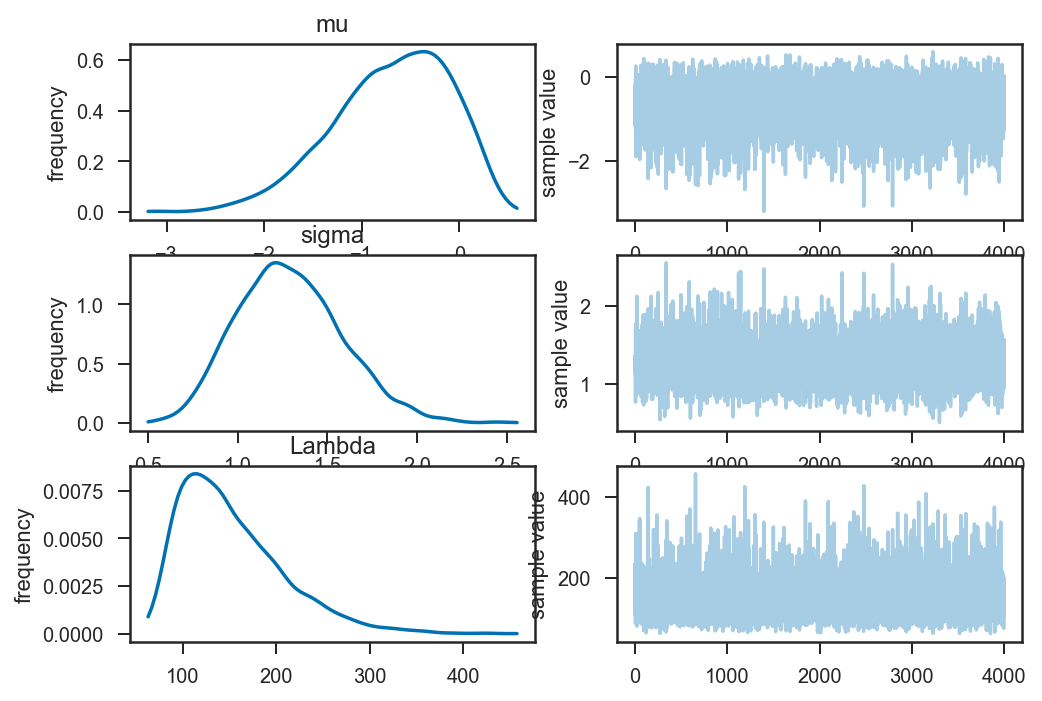

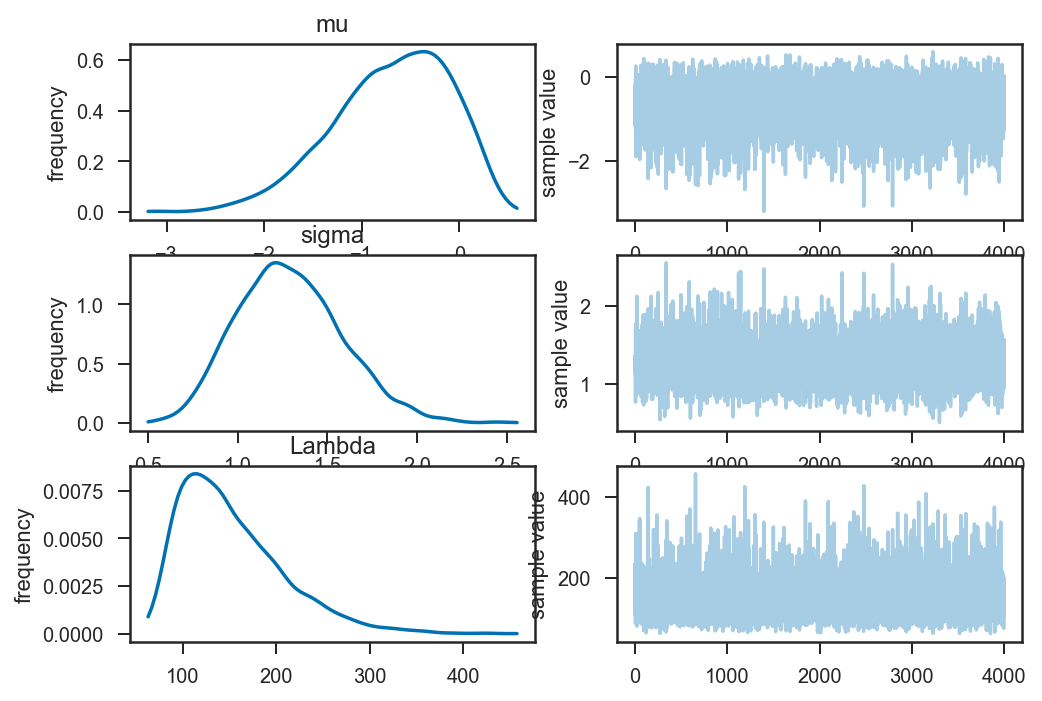

In [44]:
fit_analytic.plot(['mu', 'sigma', 'Lambda'])

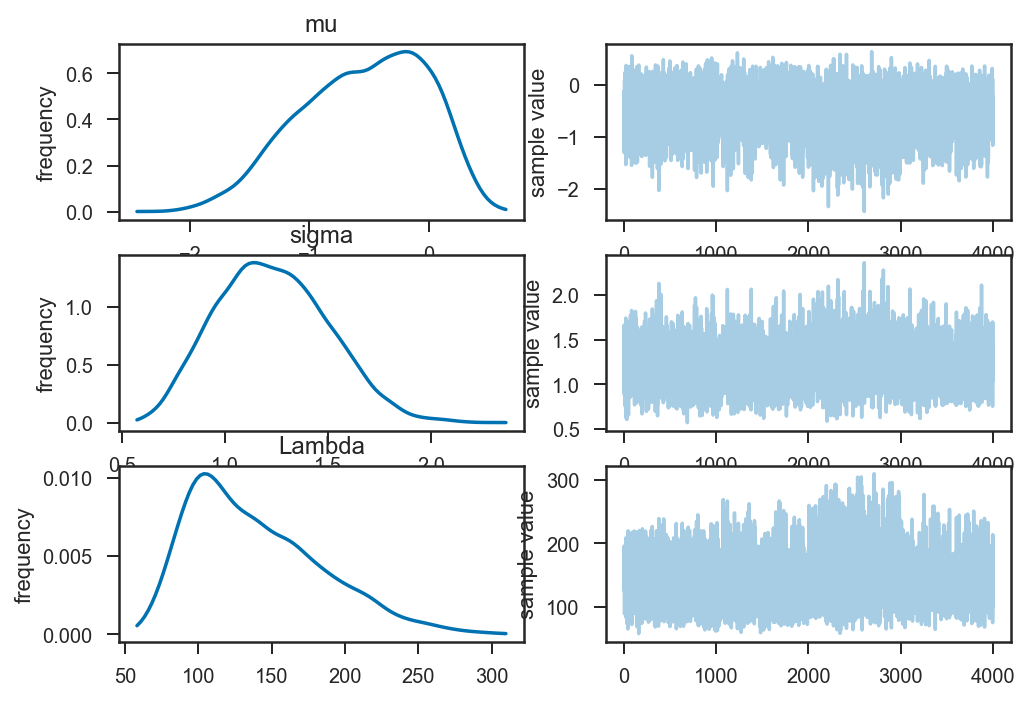

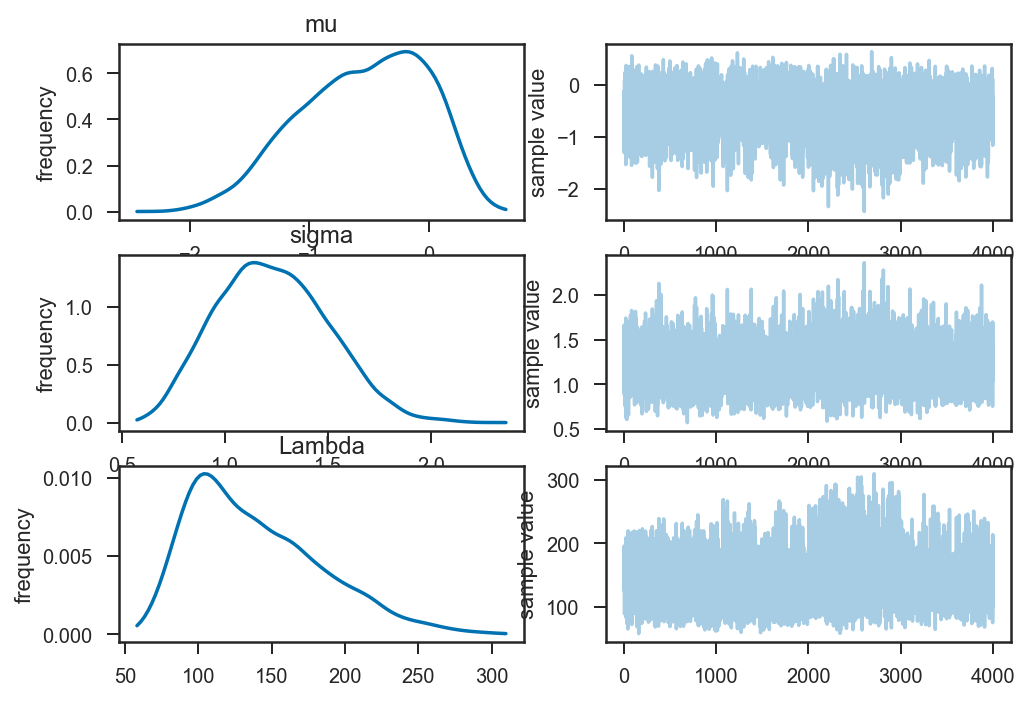

In [45]:
fit.plot(['mu', 'sigma', 'Lambda'])

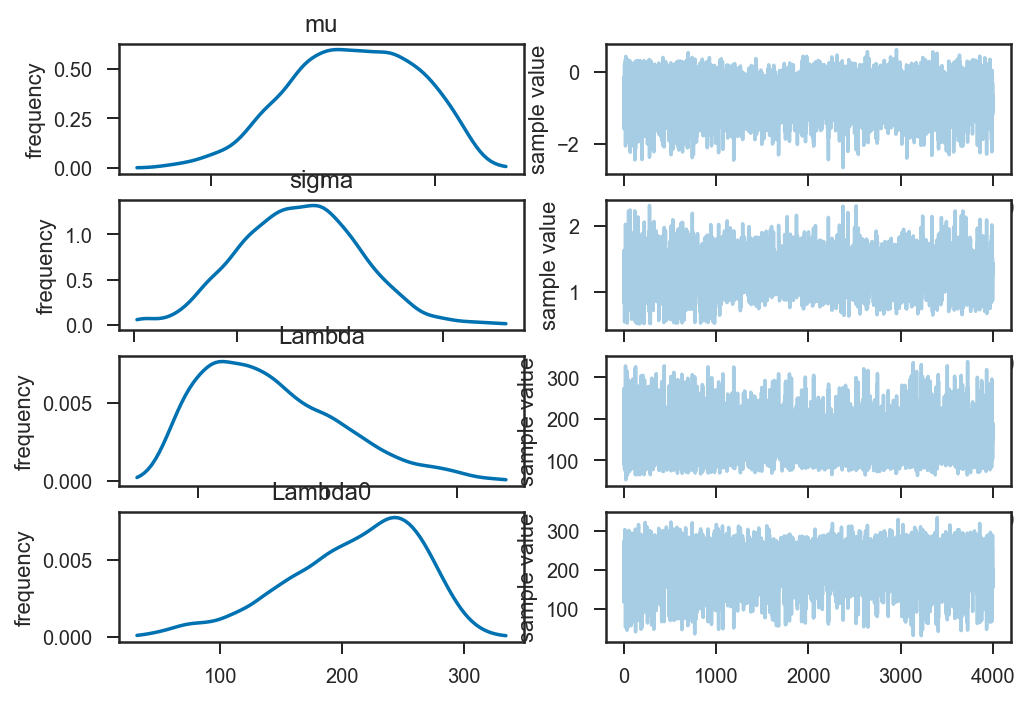

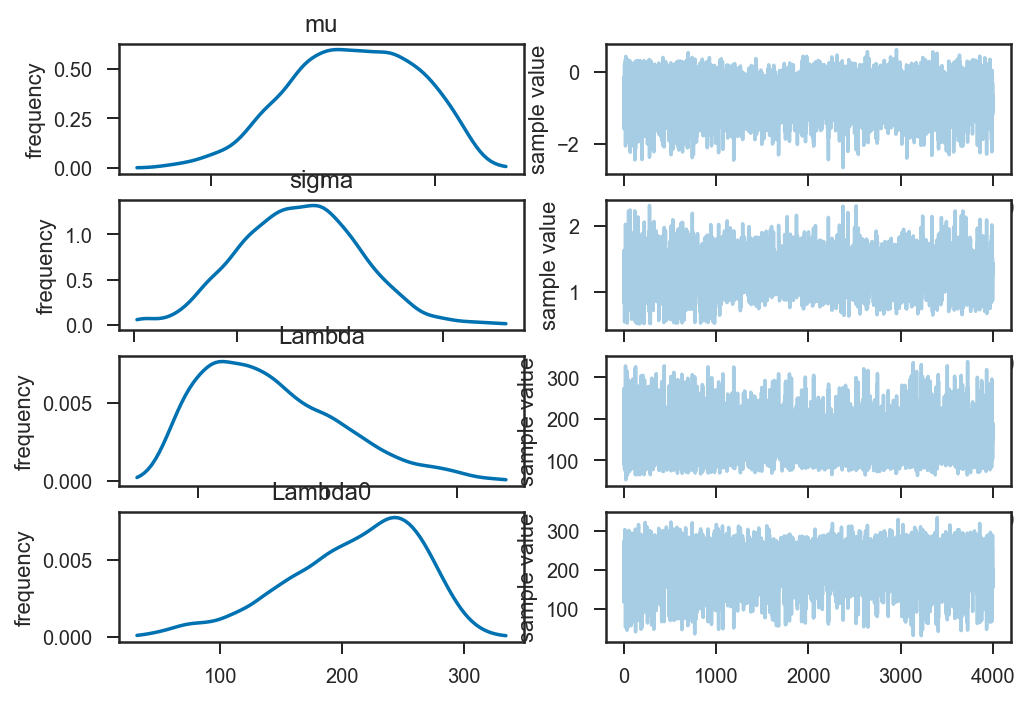

In [46]:
fit_mixture.plot(['mu', 'sigma', 'Lambda', 'Lambda0'])

And now a comparison of the 1D marginals of the population-level parameters among the three different methods, plus truth:

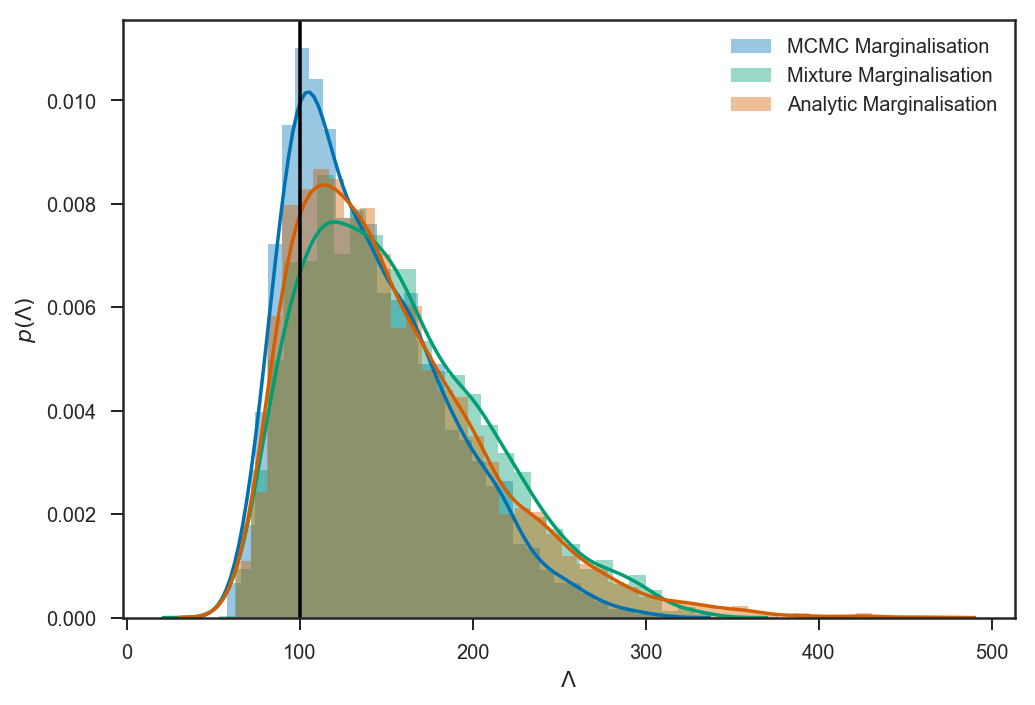

In [58]:
sns.distplot(chain['Lambda'], label='MCMC Marginalisation')
sns.distplot(chain_mixture['Lambda'], label='Mixture Marginalisation')
sns.distplot(chain_analytic['Lambda'], label='Analytic Marginalisation')
legend(loc='best')
axvline(100, color='k')
xlabel(r'$\Lambda$')
ylabel(r'$p\left( \Lambda \right)$')

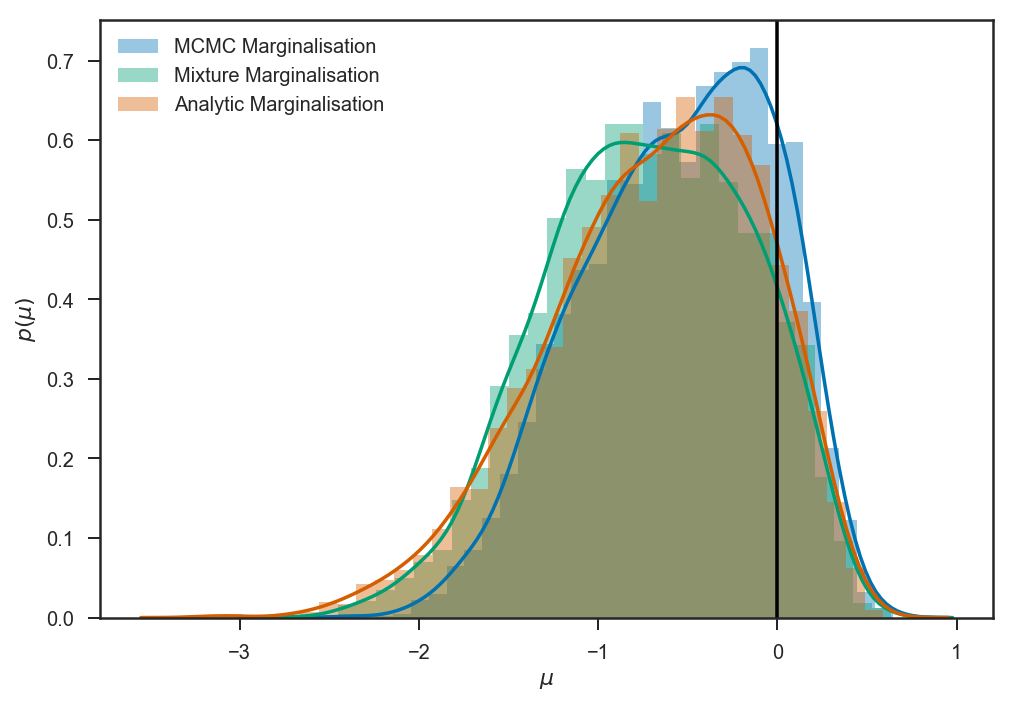

In [59]:
sns.distplot(chain['mu'], label='MCMC Marginalisation')
sns.distplot(chain_mixture['mu'], label='Mixture Marginalisation')
sns.distplot(chain_analytic['mu'], label='Analytic Marginalisation')
legend(loc='best')
xlabel(r'$\mu$')
ylabel(r'$p\left( \mu \right)$')
axvline(0, color='k')

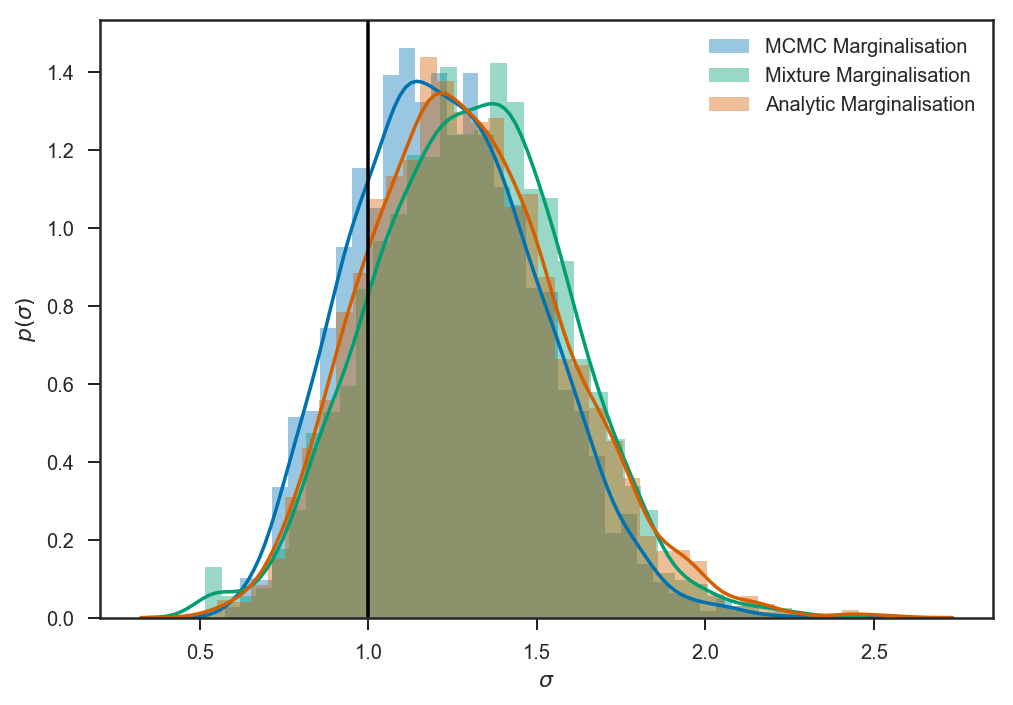

In [60]:
sns.distplot(chain['sigma'], label='MCMC Marginalisation')
sns.distplot(chain_mixture['sigma'], label='Mixture Marginalisation')
sns.distplot(chain_analytic['sigma'], label='Analytic Marginalisation')
legend(loc='best')
xlabel(r'$\sigma$')
ylabel(r'$p\left( \sigma \right)$')
axvline(1, color='k')

And finally a 2D comparison in the population-distribution parameter space:

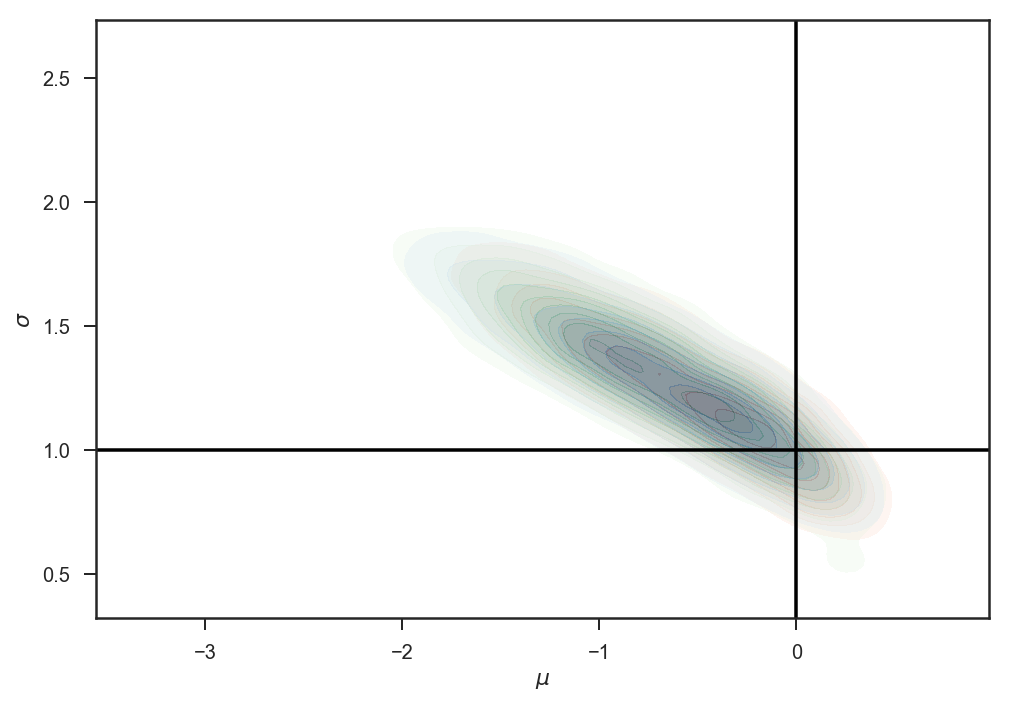

In [63]:
sns.kdeplot(chain['mu'], chain['sigma'], label='MCMC', cmap='Reds', shade=True, alpha=0.25, shade_lowest=False)
sns.kdeplot(chain_mixture['mu'], chain_mixture['sigma'], label='Mixture', cmap='Greens', shade=True, alpha=0.25, shade_lowest=False)
sns.kdeplot(chain_analytic['mu'], chain_analytic['sigma'], label='Analytic', cmap='Blues', shade=True, alpha=0.25, shade_lowest=False)
axvline(0, color='k')
axhline(1, color='k')
xlabel(r'$\mu$')
ylabel(r'$\sigma$')

One final way (not shown) to perform the simulation would be to *Gibbs sample* the non-detected population at the same time as running an MCMC over the population-level parameters.  Since we have a generative model for the population, we can draw a complete population given population-level parameters, and draw observations of this population from the appropriate likelihood function; keeping only the non-detected subset of the draw, the likelihood for the MCMC step is 
$$
\mathcal{L} = \left[ \prod_{i=1}^{N_\mathrm{det}} \Lambda P_\mathrm{det}\left( x_\mathrm{obs}^i \right) p\left( x_\mathrm{obs}^i \mid x^i \right) p\left( x^i \mid \mu, \sigma \right) \right] \left[ \prod_{j=1}^{N_\mathrm{ndet}} \Lambda \left( 1 - P_\mathrm{det}\left( x_\mathrm{obs}^j \right)\right) p\left( x_\mathrm{obs}^j \mid x^j \right) p\left( x^j \mid \mu, \sigma \right) \right] \exp\left[ -\Lambda \right].
$$
MCMC steps should alternate with fresh draws of the $N_\mathrm{ndet}$ non-detected population at the current values of the population parameters.